In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
#dropout ewerynode is dropout randomly at each iteration, avoid overfitting,
#robust: does not rely too much on a single node
from tensorflow.keras.optimizers import SGD
#adam ecc are already available
import time
import math

In [57]:
fname = "sequences16.csv"
sx, sy = np.loadtxt(fname, delimiter=',',
                   usecols=(0,1), unpack=True, dtype=str)
N=len(sy)
print(N)
Ls=len(sx[0])
print(Ls)

print(sx[0], sy[0])

perc_train=0.7
N_train= int(N*perc_train)
N_test = N-N_train
print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_test}')

3000
16
AAGGTCTGCCGGCCGA 1

data: 3000
train: 2100
test: 900


In [58]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}
print(onehc)

y = sy.astype(int)
L = Ls*Nc
print(L)#length of array feeding NN

x = np.zeros((N, L))
print(x[0])

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1 #for every step in string you jump of 4 i the autoencpding
        
print(sx[0], x[0])    
print(type(y))


{'A': 0, 'C': 1, 'G': 2, 'T': 3}
64
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AAGGTCTGCCGGCCGA [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
<class 'numpy.ndarray'>


## Point 1

In [59]:
x_train, y_train = x[:N_train], y[:N_train]
x_test, y_test = x[N_train:], y[N_train:]

score_train = y_train.sum()/len(y_train)
score_test = y_test.sum()/len(y_test)
print(score_train, score_test)


0.24714285714285714 0.24444444444444444


In [60]:
np.random.seed(123)

model = Sequential()
model.add(Dense(L, input_shape=(L,), activation='relu'))
model.add(Dense(L/2, activation='relu'))
model.add(Dense(L/4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_133 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_134 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
42/42 [==============================] - 3s 19ms/step - loss: 0.6575 - accuracy: 0.6247 - val_loss: 0.5528 - val_accuracy: 0.7556
Epoch 2/30
42/42 [==============================] - 0s 9ms/step - loss: 0.5599 - accuracy: 0.7501 - val_loss: 0.5344 - val_accuracy: 0.7556
Epoch 3/30
42/42 [==============================] - 1s 12ms/step - loss: 0.5328 - accuracy: 0.7478 - val_loss: 0.5099 - val_accuracy: 0.7544
Epoch 4/30
42/42 [==============================] - 0s 9ms/step - loss: 0.4745 - accuracy: 0.7780 - val_loss: 0.4900 - val_accuracy: 0.7556
Epoch 5/30
42/42 [==============================] - ETA: 0s - loss: 0.4757 - accuracy: 0.76 - 0s 9ms/step - loss: 0.4737 - accuracy: 0.7684 - val_loss: 0.4804 - val_accuracy: 0.7622
Epoch 6/30
42/42 [==============================] - 1s 10ms/step - loss: 0.4544 - accuracy: 0.7867 - val_loss: 0.4714 - val_accuracy: 0.7689
Epoch 7/30
42/42 [==============================] - 0s 10ms/step - loss: 0.4243 - accuracy: 0.8028 - val_loss: 0.46

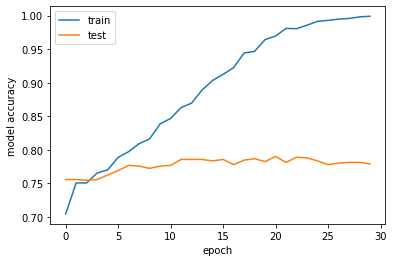

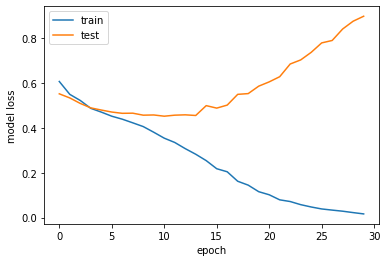

In [61]:
model.compile(loss='binary_crossentropy',
             optimizer='ADAM',
             metrics=['accuracy'])


fit = model.fit(x_train, y_train,
               epochs=30, batch_size=50,
               validation_data=(x_test, y_test),
               shuffle=True #changes composition of mini batch                                
               )


score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Data augmentation

In [62]:
sx_train = sx[:N_train]
sx_train_augm = []
y_train_augm = []

def shifting(x, positions, label):
    #function that shifts our srings
    shifted_x = []
    shifted_y =  []
    
    shifted_x.append(x)
    shifted_y.append(label)
    
    temp = x
    
    for j in range(positions):
        temp = temp[-1:]+temp[:-1]
        shifted_x.append(temp)
        shifted_y.append(label)
             
    return shifted_x, shifted_y
            
position = 15       

for i in range(len(sx_train)):
    sx_train_augm += shifting(sx_train[i], position, y_train[i])[0]
    y_train_augm += shifting(sx_train[i], position, y_train[i])[1]   

In [63]:
N_augm = len(sx_train_augm)

In [64]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}
print(onehc)

y = sy.astype(int)
L = Ls*Nc

print(L)#length of array feeding NN

x_train_augm = np.zeros((N_augm, L))

for n in range(N_augm):
    for i in range(Ls):
        x_train_augm[n][i*4 + onehc[sx_train_augm[n][i]]] = 1 #for every step in string you jump of 4 i the autoencpding
        
print( type(y_train_augm) )   

{'A': 0, 'C': 1, 'G': 2, 'T': 3}
64
<class 'list'>


In [65]:
np.random.seed(123)

model_aug = Sequential()
model_aug.add(Dense(L, input_shape=(L,), activation='relu'))
model_aug.add(Dense(L/2, activation='relu'))
model_aug.add(Dense(L/4, activation='relu'))
model_aug.add(Dropout(0.2))
model_aug.add(Dense(1, activation='sigmoid'))

print(model_aug.summary())

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_137 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_138 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_34 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
model_aug.compile(loss='binary_crossentropy',
             optimizer='ADAM',
             metrics=['accuracy'])


fit_aug = model_aug.fit(np.asarray(x_train_augm), np.asarray(y_train_augm),
               epochs=30, batch_size=500,
               validation_data=(x_test, y_test),
               shuffle=True #changes composition of mini batch                                
               )

score = model_aug.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
68/68 [==============================] - 2s 13ms/step - loss: 0.5936 - accuracy: 0.7124 - val_loss: 0.5137 - val_accuracy: 0.7556
Epoch 2/30
68/68 [==============================] - 1s 11ms/step - loss: 0.5170 - accuracy: 0.7516 - val_loss: 0.4782 - val_accuracy: 0.7722
Epoch 3/30
68/68 [==============================] - 1s 8ms/step - loss: 0.4891 - accuracy: 0.7701 - val_loss: 0.4625 - val_accuracy: 0.7944
Epoch 4/30
68/68 [==============================] - 1s 9ms/step - loss: 0.4682 - accuracy: 0.7818 - val_loss: 0.4329 - val_accuracy: 0.8056
Epoch 5/30
68/68 [==============================] - 1s 10ms/step - loss: 0.4299 - accuracy: 0.8022 - val_loss: 0.3882 - val_accuracy: 0.8211
Epoch 6/30
68/68 [==============================] - 1s 9ms/step - loss: 0.3941 - accuracy: 0.8231 - val_loss: 0.3615 - val_accuracy: 0.8289
Epoch 7/30
68/68 [==============================] - 1s 9ms/step - loss: 0.3522 - accuracy: 0.8454 - val_loss: 0.3340 - val_accuracy: 0.8456
Epoch 8/30
68/68 

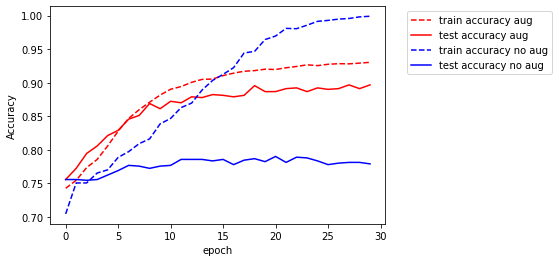

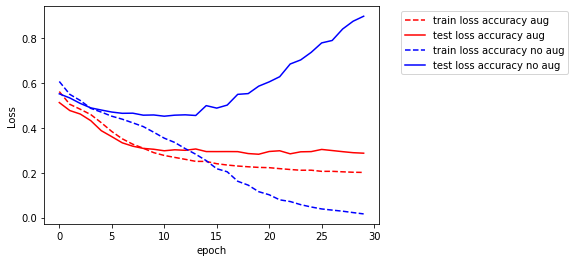

In [67]:
# look into training history

# summarize history for accuracy
plt.plot(fit_aug.history['accuracy'],
         label='train accuracy aug',
         c='red',
         ls='--'
        )
plt.plot(fit_aug.history['val_accuracy'],
         label='test accuracy aug',
         c='red'
        )
plt.plot(fit.history['accuracy'],
         label='train accuracy no aug',
         c='blue',
         ls='--'
        )
plt.plot(fit.history['val_accuracy'], label='test accuracy no aug',c='blue')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# summarize history for loss
plt.plot(fit_aug.history['loss'], label='train loss accuracy aug', c='red', ls='--')
plt.plot(fit_aug.history['val_loss'], label='test loss accuracy aug',c='red')
plt.plot(fit.history['loss'], label='train loss accuracy no aug',c='blue',ls='--')
plt.plot(fit.history['val_loss'], label='test loss accuracy no aug',c='blue')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

It enlarges the number of good samples
Podemo anca provar a cambiare el numero de shifting


## Grid Search

In [27]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [40]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop'):
    # create model
    model_grid = Sequential()
    model_grid.add(Dense(L, input_shape=(L,), activation='relu'))
    model_grid.add(Dense(L/2, activation='relu'))
    model_grid.add(Dropout(0.2))
    model_grid.add(Dense(1, activation='sigmoid'))

    model_grid.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )
    return model_grid
 
# create model 
model_gridsearch = KerasClassifier(build_fn=create_model, 
                        epochs=30, 
                        batch_size=800,
                        verbose=0)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adam']
activations = ['relu', 'elu', 'sigmoid', 'tanh']
dropout_rates = [0.1,0.2,0.3,0.4,0.5]
learning_rates = [10**-4,10**-3,10**-2,10**-1]

# define parameter dictionary
param_grid = dict(optimizer=optimizer,
                  activations = activations,
                  dropout_rates=dropout_rates,
                 learning_rates=learning_rates)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch,
                    param_grid=param_grid,
                    n_jobs = 1,
                    cv=4)
grid_result = grid.fit(np.asarray(x_train_augm),np.asarray(y_train_augm))

Epoch 1/30
504/504 [==============================] - 2s 2ms/step - loss: 0.6006 - accuracy: 0.7382: 0s - loss: 0.6039 - accuracy: 
Epoch 2/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5532 - accuracy: 0.7472: 0s - loss: 0.5
Epoch 3/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7452
Epoch 4/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5285 - accuracy: 0.7530
Epoch 5/30
504/504 [==============================] - 1s 3ms/step - loss: 0.5255 - accuracy: 0.7478: 1s -
Epoch 6/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5183 - accuracy: 0.7498
Epoch 7/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5121 - accuracy: 0.7530: 0s - loss: 0
Epoch 8/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5112 - accuracy: 0.7510
Epoch 9/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5050 - accuracy: 0.7562
Epoch 10/30
504/504 [===========

Epoch 16/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4631 - accuracy: 0.7886
Epoch 17/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4528 - accuracy: 0.7942
Epoch 18/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4513 - accuracy: 0.7939
Epoch 19/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4454 - accuracy: 0.7977
Epoch 20/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4409 - accuracy: 0.7987
Epoch 21/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4345 - accuracy: 0.8000
Epoch 22/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4306 - accuracy: 0.8041
Epoch 23/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4214 - accuracy: 0.8119
Epoch 24/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4063 - accuracy: 0.8203
Epoch 25/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4020 - accurac

504/504 [==============================] - 1s 2ms/step - loss: 0.4202 - accuracy: 0.8122
Epoch 4/30
504/504 [==============================] - 2s 3ms/step - loss: 0.3634 - accuracy: 0.8459
Epoch 5/30
504/504 [==============================] - 2s 5ms/step - loss: 0.3234 - accuracy: 0.8609: 3s - loss: 0 - E
Epoch 6/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2981 - accuracy: 0.8759
Epoch 7/30
504/504 [==============================] - 1s 3ms/step - loss: 0.2718 - accuracy: 0.8879
Epoch 8/30
504/504 [==============================] - 2s 3ms/step - loss: 0.2591 - accuracy: 0.8970
Epoch 9/30
504/504 [==============================] - 2s 4ms/step - loss: 0.2423 - accuracy: 0.9027
Epoch 10/30
504/504 [==============================] - 1s 3ms/step - loss: 0.2280 - accuracy: 0.9116
Epoch 11/30
504/504 [==============================] - 2s 3ms/step - loss: 0.2197 - accuracy: 0.9153
Epoch 12/30
504/504 [==============================] - 2s 4ms/step - loss: 0.2164 - accurac

Epoch 20/30
504/504 [==============================] - 1s 3ms/step - loss: 0.1948 - accuracy: 0.9324
Epoch 21/30
504/504 [==============================] - 1s 3ms/step - loss: 0.1913 - accuracy: 0.9324
Epoch 22/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1891 - accuracy: 0.9340
Epoch 23/30
504/504 [==============================] - 1s 3ms/step - loss: 0.1947 - accuracy: 0.9304
Epoch 24/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1923 - accuracy: 0.9344
Epoch 25/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1800 - accuracy: 0.9380
Epoch 26/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1860 - accuracy: 0.9363
Epoch 27/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1848 - accuracy: 0.9382
Epoch 28/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1779 - accuracy: 0.9409
Epoch 29/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1780 - accurac

504/504 [==============================] - 1s 2ms/step - loss: 0.5561 - accuracy: 0.7573
Epoch 6/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7617
Epoch 7/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5519 - accuracy: 0.7554
Epoch 8/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5457 - accuracy: 0.7592
Epoch 9/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7577: 0s - loss: 0.5460 - ac
Epoch 10/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5380 - accuracy: 0.7620
Epoch 11/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5400 - accuracy: 0.7558
Epoch 12/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5406 - accuracy: 0.7560
Epoch 13/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5325 - accuracy: 0.7613
Epoch 14/30
504/504 [==============================] - 1s 3ms/step - loss: 0.5383 -

504/504 [==============================] - 1s 2ms/step - loss: 0.6083 - accuracy: 0.7307
Epoch 21/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6086 - accuracy: 0.7283
Epoch 22/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6057 - accuracy: 0.7336
Epoch 23/30
504/504 [==============================] - 2s 4ms/step - loss: 0.6029 - accuracy: 0.7360
Epoch 24/30
504/504 [==============================] - 1s 3ms/step - loss: 0.6008 - accuracy: 0.7353
Epoch 25/30
504/504 [==============================] - 2s 3ms/step - loss: 0.5964 - accuracy: 0.7399
Epoch 26/30
504/504 [==============================] - 2s 3ms/step - loss: 0.5984 - accuracy: 0.7366
Epoch 27/30
504/504 [==============================] - 1s 3ms/step - loss: 0.5931 - accuracy: 0.7426
Epoch 28/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5931 - accuracy: 0.7396
Epoch 29/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5942 - accuracy: 0.7375: 0

Epoch 7/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6310 - accuracy: 0.6976
Epoch 8/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6240 - accuracy: 0.7071
Epoch 9/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6209 - accuracy: 0.7129
Epoch 10/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6149 - accuracy: 0.7149
Epoch 11/30
504/504 [==============================] - 1s 3ms/step - loss: 0.6119 - accuracy: 0.7225: 0s - loss: 0.6
Epoch 12/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6085 - accuracy: 0.7254
Epoch 13/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6045 - accuracy: 0.7260
Epoch 14/30
504/504 [==============================] - 1s 2ms/step - loss: 0.6015 - accuracy: 0.7302
Epoch 15/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5960 - accuracy: 0.7357
Epoch 16/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5

504/504 [==============================] - 1s 2ms/step - loss: 0.1445 - accuracy: 0.9499
Epoch 24/30
504/504 [==============================] - 2s 3ms/step - loss: 0.1416 - accuracy: 0.9518: 0s - los
Epoch 25/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1400 - accuracy: 0.9506
Epoch 26/30
504/504 [==============================] - 1s 2ms/step - loss: 0.1331 - accuracy: 0.9535
Epoch 27/30
504/504 [==============================] - 1s 3ms/step - loss: 0.1328 - accuracy: 0.9542
Epoch 28/30
504/504 [==============================] - 2s 3ms/step - loss: 0.1335 - accuracy: 0.9526
Epoch 29/30
504/504 [==============================] - 1s 3ms/step - loss: 0.1261 - accuracy: 0.9556
Epoch 30/30
168/168 [==============================] - 1s 4ms/step - loss: 0.4958 - accuracy: 0.8551
Epoch 1/30
504/504 [==============================] - 2s 2ms/step - loss: 0.5445 - accuracy: 0.7410
Epoch 2/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4642 - accuracy: 0

504/504 [==============================] - 1s 2ms/step - loss: 0.3523 - accuracy: 0.8424
Epoch 11/30
504/504 [==============================] - 1s 2ms/step - loss: 0.3347 - accuracy: 0.8582
Epoch 12/30
504/504 [==============================] - 1s 2ms/step - loss: 0.3213 - accuracy: 0.8620
Epoch 13/30
504/504 [==============================] - 1s 2ms/step - loss: 0.3131 - accuracy: 0.8664
Epoch 14/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2968 - accuracy: 0.8775
Epoch 15/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2889 - accuracy: 0.8798
Epoch 16/30
504/504 [==============================] - 2s 3ms/step - loss: 0.2832 - accuracy: 0.8837
Epoch 17/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2710 - accuracy: 0.8908: 
Epoch 18/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2679 - accuracy: 0.8911
Epoch 19/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2578 - accuracy: 0.8994


Epoch 28/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2294 - accuracy: 0.9157
Epoch 29/30
504/504 [==============================] - 1s 2ms/step - loss: 0.2259 - accuracy: 0.9178
Epoch 30/30
168/168 [==============================] - 0s 1ms/step - loss: 0.3033 - accuracy: 0.8758: 0s - loss: 0.3147 - accuracy: 0.87
Epoch 1/30
504/504 [==============================] - 1s 1ms/step - loss: 0.5854 - accuracy: 0.7081: 0s - loss: 0.6119 - 
Epoch 2/30
504/504 [==============================] - 1s 2ms/step - loss: 0.5019 - accuracy: 0.7586
Epoch 3/30
504/504 [==============================] - 1s 1ms/step - loss: 0.4902 - accuracy: 0.7707
Epoch 4/30
504/504 [==============================] - 1s 1ms/step - loss: 0.4703 - accuracy: 0.7846: 0s - loss: 0.4697 - accuracy
Epoch 5/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4594 - accuracy: 0.7891
Epoch 6/30
504/504 [==============================] - 1s 2ms/step - loss: 0.4404 - accuracy: 0.7984
Epoch 7/3

504/504 [==============================] - 1s 1ms/step - loss: 0.1779 - accuracy: 0.9365
Epoch 15/30
504/504 [==============================] - 1s 1ms/step - loss: 0.1751 - accuracy: 0.9362
Epoch 16/30
504/504 [==============================] - 1s 1ms/step - loss: 0.1712 - accuracy: 0.9388
Epoch 17/30
504/504 [==============================] - 0s 975us/step - loss: 0.1638 - accuracy: 0.9410
Epoch 18/30
504/504 [==============================] - 1s 1ms/step - loss: 0.1610 - accuracy: 0.9449
Epoch 19/30
504/504 [==============================] - 1s 1ms/step - loss: 0.1596 - accuracy: 0.9414
Epoch 20/30
504/504 [==============================] - 1s 1ms/step - loss: 0.1558 - accuracy: 0.9444
Epoch 21/30
504/504 [==============================] - 1s 995us/step - loss: 0.1545 - accuracy: 0.9438
Epoch 22/30
504/504 [==============================] - 1s 998us/step - loss: 0.1539 - accuracy: 0.9443
Epoch 23/30
504/504 [==============================] - 1s 1ms/step - loss: 0.1559 - accuracy: 0.9

672/672 [==============================] - 1s 924us/step - loss: 0.5463 - accuracy: 0.7325
Epoch 2/30
672/672 [==============================] - 1s 943us/step - loss: 0.4348 - accuracy: 0.7986
Epoch 3/30
672/672 [==============================] - 1s 949us/step - loss: 0.3446 - accuracy: 0.8549
Epoch 4/30
672/672 [==============================] - 1s 942us/step - loss: 0.2973 - accuracy: 0.8765
Epoch 5/30
672/672 [==============================] - 1s 938us/step - loss: 0.2682 - accuracy: 0.8942
Epoch 6/30
672/672 [==============================] - 1s 952us/step - loss: 0.2526 - accuracy: 0.9013
Epoch 7/30
672/672 [==============================] - 1s 938us/step - loss: 0.2359 - accuracy: 0.9131
Epoch 8/30
672/672 [==============================] - 1s 951us/step - loss: 0.2285 - accuracy: 0.9153
Epoch 9/30
672/672 [==============================] - 1s 936us/step - loss: 0.2226 - accuracy: 0.9178
Epoch 10/30
672/672 [==============================] - 1s 955us/step - loss: 0.2164 - accurac

In [41]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.873929 using {'optimizer': 'Nadam'}
0.816726 (0.010377) with: {'optimizer': 'SGD'}
0.872708 (0.007509) with: {'optimizer': 'RMSprop'}
0.757679 (0.013907) with: {'optimizer': 'Adagrad'}
0.752857 (0.012150) with: {'optimizer': 'Adadelta'}
0.873571 (0.011931) with: {'optimizer': 'Adam'}
0.869286 (0.007056) with: {'optimizer': 'Adamax'}
0.873929 (0.005747) with: {'optimizer': 'Nadam'}
